In [2]:
import numpy as np
import pandas as pd
from aerobot.io import RESULTS_PATH, ASSET_PATH, FEATURE_TYPES
from aerobot.dataset import dataset_load_all, dataset_load_feature_order
from aerobot.models import GeneralClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticks
from scipy.stats import linregress

In [3]:
EMB_RESULTS_PATH = os.path.join(RESULTS_PATH, 'earth_microbiome')
BS_RESULTS_PATH = os.path.join(RESULTS_PATH, 'black_sea')

## Running model on EMP data

bs data is stored on HPC under `/central/groups/fischergroup/goldford/earth_microbiome/proteins`. The data file has a column for each amino acid trimer (there are over 9000). I think I will need to filter the features to match the features the model was trained on, as several columns are dropped when loading the raw feature data into a `dataset`.

In [ ]:
# sbatch --mem 64GB --time 3:00:00 --wrap "python run-pretrained.py ../notebooks/aa_3mer_nonlinear_model.joblib ../../results/earth_microbiome/emb_aa_3mer.csv -o ../../results/earth_microbiome/run_pretrained_results_nonlinear_aa_3mer.csv"

In [8]:
# First step is to train a nonlinear model on the training data. 
! python ../scripts/run.py 'nonlinear' --feature-type 'aa_3mer' --save-model 1 --n-epochs 500 --save-model-path 'aa_3mer_nonlinear_model.joblib'

# Training NonlinearClassifier...: 100%|██████| 500/500 [1:04:58<00:00,  7.80s/it]

# Results of training a nonlinear classifier for ternary classification.
# 	Feature type: aa_3mer
# 	Balanced accuracy on training dataset: 0.9595037868370083
# 	Balanced accuracy on validation dataset: 0.8049397220160904

# Writing results to run_model_results.pkl.
# Saving trained model to aa_3mer_nonlinear_model.joblib.

# Model run complete in 3185.19 seconds.

Training NonlinearClassifier...: 100%|██████| 500/500 [1:04:58<00:00,  7.80s/it]

Results of training a nonlinear classifier for ternary classification.
	Feature type: aa_3mer
	Balanced accuracy on training dataset: 0.9595037868370083
	Balanced accuracy on validation dataset: 0.8049397220160904

Writing results to run_model_results.pkl.
Saving trained model to aa_3mer_nonlinear_model.joblib.

Model run complete in 3185.19 seconds.


In [12]:
# Also train a logistic model on the training data. 
! python ../scripts/run.py 'logistic' --feature-type 'aa_3mer' --save-model 1 --max-iter 10000 --save-model-path 'aa_3mer_logistic_model.joblib'

/home/prichter/miniconda3/envs/aerobot/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

Results of training a logistic classifier for ternary classification.
	Feature type: aa_3mer
	Balanced accuracy on training dataset: 0.9966855466845016
	Balanced accuracy on validation dataset: 0.7815291401001003

Writing results to run_model_results.pkl.
Saving trained model to aa_3mer_logistic_model.joblib.

Model run complete in 3.95 seconds.


In [7]:
# Get a subset of the data for testing.
# emb_data = pd.read_csv(os.path.join(EMB_RESULTS_PATH, 'emb_aa_3mer.csv'), nrows=200, index_col=0)
# bs_data.to_csv(os.path.join(EMB_RESULTS_PATH, 'emb_aa_3mer_subset.csv'))

## Earth Microbiome Project

### Comparing to original

In [4]:
# Load the original run of the logistic classifier
emb_predictions_original_df = pd.read_csv(os.path.join(EMB_RESULTS_PATH, f'original_run_results_logistic_aa_3mer.csv'), index_col=0)
emb_predictions_original_df = emb_predictions_original_df.rename(columns={'label':'prediction'})
emb_predictions_original_df.prediction = emb_predictions_original_df.prediction.str.lower()
# Load my (Pippa's) run of the logistic classifier on the new data. 
emb_predictions_logistic_df = pd.read_csv(os.path.join(EMB_RESULTS_PATH, f'run_pretrained_results_logistic_aa_3mer.csv'), index_col=0)
# Load my (Pippa's) run of the nonlinear classifier on the new data. 
emb_predictions_nonlinear_df = pd.read_csv(os.path.join(EMB_RESULTS_PATH, f'run_pretrained_results_nonlinear_aa_3mer.csv'), index_col=0)

print('Predictions from original run:')
print(emb_predictions_original_df.prediction.value_counts())

print('\nPredictions from new logistic run:')
print(emb_predictions_logistic_df.prediction.value_counts())

print('\nPredictions from new nonlinear run:')
print(emb_predictions_nonlinear_df.prediction.value_counts())


Predictions from original run:
prediction
anaerobe       26735
aerobe         23420
facultative     2360
Name: count, dtype: int64

Predictions from new logistic run:
prediction
anaerobe       28905
aerobe         20915
facultative     2695
Name: count, dtype: int64

Predictions from new nonlinear run:
prediction
anaerobe       35147
aerobe         13656
facultative     3712
Name: count, dtype: int64


### Cleaning data

In [5]:
model_class = 'nonlinear'

In [6]:
# Load the Earth microbiome project analysis and metadata
emb_metadata_df = pd.read_csv(os.path.join(EMB_RESULTS_PATH, 'emb_metadata.tsv'), sep='\t', index_col=0, dtype={'metagenome_id':str})
emb_predictions_df = pd.read_csv(os.path.join(EMB_RESULTS_PATH, f'run_pretrained_results_{model_class}_aa_3mer.csv'), index_col=0)
# emb_predictions_df.index = emb_metadata_df.index # I think this is OK? Indices should match, no scrambling happens during predictions.
print('Number of predictions:', len(emb_predictions_df))
print('Number of metadata entries:', len(emb_metadata_df))
# Combine the predictions and metadata.
emb_predictions_df = pd.concat([emb_metadata_df, emb_predictions_df], axis=1)
print('Number of entries after concatenating DataFrames:', len(emb_predictions_df))

Number of predictions: 52515
Number of metadata entries: 52515
Number of entries after concatenating DataFrames: 52515


In [7]:
# Replace habitat names with more general categories.
habitat_map = pd.read_csv(os.path.join(EMB_RESULTS_PATH, 'emb_habitats.csv'), index_col=0).to_dict()['habitat']
emb_predictions_df.habitat = emb_predictions_df.habitat.replace(habitat_map)

In [8]:
# Filter out low-completeness MAGs.
emb_predictions_df = emb_predictions_df[emb_predictions_df.completeness > 50]
print(len(emb_predictions_df), 'genomes with >50 percent completeness.')

# Filter out entries from samples with fewer than ten MAGs
counts = emb_predictions_df.groupby('metagenome_id').apply(len)
ids_to_keep = counts.index[counts > 10]
emb_predictions_df = emb_predictions_df[emb_predictions_df.metagenome_id.isin(ids_to_keep)]
print(len(emb_predictions_df), 'genomes from samples with more than ten genomes.')

# Filter our habitats with fewer than ten samples.
counts = emb_predictions_df.groupby('habitat').apply(len)
habitats_to_keep = counts.index[counts > 10]
emb_predictions_df = emb_predictions_df[emb_predictions_df.habitat.isin(habitats_to_keep)]
print(len(emb_predictions_df), 'genomes from habitats with more than ten samples')

52425 genomes with >50 percent completeness.


31279 genomes from samples with more than ten genomes.
31279 genomes from habitats with more than ten samples


In [9]:
# Calculate the aerobe-anaerobe-facultative fractions for each sample.
# NOTE: What is the labels column used in the original code? The prediction? Probably.

classes = set(emb_predictions_df.prediction.values) # Get the metabolic categories.
print('Metabolic categories found in the predictions:', classes)

index, rows = [], []
# Iterate through the groups of metagenomes.
for metagenome_id, df in emb_predictions_df.groupby('metagenome_id'):
    counts = df.prediction.value_counts()
    row = counts.astype(float) / counts.sum()
    row = row.to_dict()
    row = {f'{k}_fraction':v for k, v in row.items()}
    row.update(counts.astype(float).to_dict())
    row['total'] = counts.sum()
    rows.append(row)
    index.append(metagenome_id)

fractions_df = pd.DataFrame(rows, index=index)
fractions_df = fractions_df.fillna(0)

habitats_by_metagenome_id = emb_predictions_df.groupby('metagenome_id').habitat.first() # Get the habitats for each sample.
fractions_df['habitat'] = habitats_by_metagenome_id.loc[fractions_df.index]
fractions_df['aerobe_anaerobe_ratio'] = fractions_df['aerobe_fraction'] / fractions_df['anaerobe_fraction']
fractions_df.to_csv(os.path.join(EMB_RESULTS_PATH, 'emb_fractions_by_sample.csv'))

Metabolic categories found in the predictions: {'anaerobe', 'aerobe', 'facultative'}


In [10]:
# Take the mean aerobe/anaerobe fractions across habitats.
agg = {'anaerobe': 'sum', 'aerobe': 'sum', 'facultative': 'sum', 'total': 'sum', 'aerobe_anaerobe_ratio': np.nanmean}
mean_fractions_df = fractions_df.groupby('habitat').agg(agg).sort_values('total', ascending=False)
mean_fractions_df['anaerobe_fraction'] = mean_fractions_df['anaerobe'] / mean_fractions_df['total']
mean_fractions_df['aerobe_fraction'] = mean_fractions_df['aerobe'] / mean_fractions_df['total']
mean_fractions_df['facultative_fraction'] = mean_fractions_df['facultative'] / mean_fractions_df['total']

mean_fractions_df['anaerobe_percent'] = mean_fractions_df['anaerobe_fraction'] * 100
mean_fractions_df['aerobe_percent'] = mean_fractions_df['aerobe_fraction'] * 100
mean_fractions_df['facultative_percent'] = mean_fractions_df['facultative_fraction'] * 100

mean_fractions_df.to_csv(os.path.join(EMB_RESULTS_PATH, 'emb_fractions_by_habitat.csv'))

### Plotting data

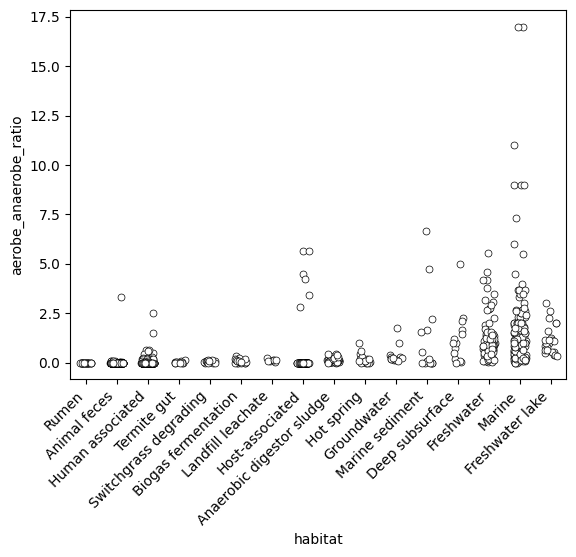

In [11]:

mean_fractions_df = pd.read_csv(os.path.join(EMB_RESULTS_PATH, 'emb_fractions_by_habitat.csv'))
fractions_df = pd.read_csv(os.path.join(EMB_RESULTS_PATH, 'emb_fractions_by_sample.csv'), index_col=0)

mean_fractions_df = mean_fractions_df[mean_fractions_df.total > 250] # Filter for habitats with more than 250 entries.
mean_fractions_df = mean_fractions_df.sort_values('aerobe_fraction', ascending=True)
fractions_df = fractions_df[fractions_df.habitat.isin(mean_fractions_df.habitat)]

fig, ax = plt.subplots()
sns.stripplot(data=fractions_df, ax=ax, x='habitat', y='aerobe_anaerobe_ratio', order=mean_fractions_df.habitat, jitter=0.2, color='white', edgecolor='k', linewidth=0.5)

ax.set_xticks(np.arange(len(mean_fractions_df.habitat)), labels=mean_fractions_df.habitat.values, rotation=45, ha='right')
plt.show()

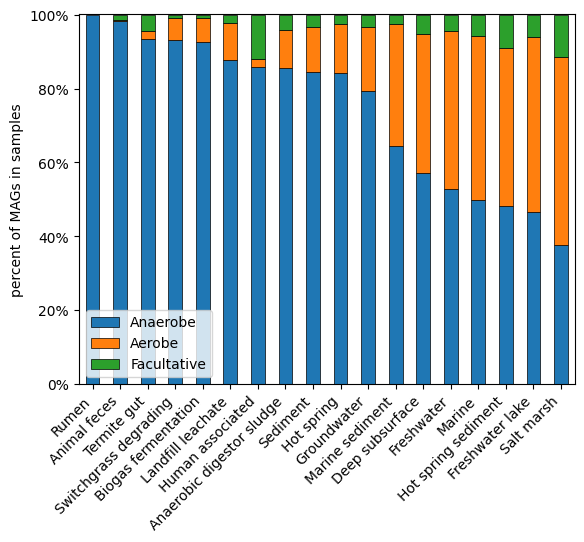

In [12]:

fig, ax = plt.subplots()
cols = ['habitat', 'anaerobe_percent', 'aerobe_percent', 'facultative_percent']
mean_fractions_df = pd.read_csv(os.path.join(EMB_RESULTS_PATH, 'emb_fractions_by_habitat.csv'))
mean_fractions_df = mean_fractions_df[(mean_fractions_df.total > 240) & ~mean_fractions_df.habitat.str.match('Host-associated')]

# Print the totals to verify that filtering worked.
# These are identical to values in original run. 
# print(mean_fractions_df[['habitat', 'total']])

mean_fractions_df = mean_fractions_df[cols].set_index('habitat').sort_values('anaerobe_percent', ascending=False)

mean_fractions_df.plot(kind='bar', stacked=True, ax=ax, legend=False, edgecolor='k', linewidth=0.5)
ax.legend(['Anaerobe', 'Aerobe', 'Facultative'], loc=3)
# ax.legend(mean_fractions_df.prediction.unique(), loc=3)
ax.set_ylabel('percent of MAGs in samples')
ax.set_xlabel('')
ax.set_xticks(np.arange(len(mean_fractions_df.index)), labels=mean_fractions_df.index.values, rotation=45, ha='right')
ax.set_ylim(0, 100.1)
ax.yaxis.set_major_formatter(ticks.PercentFormatter())


## Black sea

### Comparing to original

In [13]:
# bs_data = pd.read_csv(os.path.join(BS_RESULTS_PATH, 'bs_aa_3mer.csv'), index_col=0)
# aa_3mer_features = dataset_load_feature_order('aa_3mer')

# missing = 0
# for f in aa_3mer_features:
#     if f not in bs_data.columns:
#         missing += 1
#         # print(f'{f} missing in Black Sea data columns.')
# print('Total aa_3mer features:', len(aa_3mer_features))
# print('Total aa_3mer features in Black Sea data:', len(bs_data.columns))
# print('Total missing features in Black Sea data:', missing)

In [14]:
model_class = 'nonlinear'

In [15]:
# Load the original run of the logistic classifier
bs_predictions_original_df = pd.read_csv(os.path.join(BS_RESULTS_PATH, f'original_run_results_logistic_aa_3mer.csv'), index_col=0)
bs_predictions_original_df = bs_predictions_original_df.rename(columns={'label':'prediction'})
bs_predictions_original_df.prediction = bs_predictions_original_df.prediction.str.lower()
# Load my (Pippa's) run of the logistic classifier on the new data. 
bs_predictions_logistic_df = pd.read_csv(os.path.join(BS_RESULTS_PATH, f'run_pretrained_results_logistic_aa_3mer.csv'), index_col=0)
# Load my (Pippa's) run of the nonlinear classifier on the new data. 
bs_predictions_nonlinear_df = pd.read_csv(os.path.join(BS_RESULTS_PATH, f'run_pretrained_results_nonlinear_aa_3mer.csv'), index_col=0)

print('Predictions from original run:')
print(bs_predictions_original_df.prediction.value_counts())

print('\nPredictions from new logistic run:')
print(bs_predictions_logistic_df.prediction.value_counts())

print('\nPredictions from new nonlinear run:')
print(bs_predictions_nonlinear_df.prediction.value_counts())

Predictions from original run:
prediction
aerobe         92
anaerobe       66
facultative     2
Name: count, dtype: int64

Predictions from new logistic run:
prediction
anaerobe       85
aerobe         67
facultative     8
Name: count, dtype: int64

Predictions from new nonlinear run:
prediction
anaerobe       115
aerobe          36
facultative      9
Name: count, dtype: int64


### Cleaning data

In [16]:
# Load the black sea metadata
bs_metadata_df = pd.read_csv(os.path.join(BS_RESULTS_PATH, 'bs_metadata.csv'), index_col=0)
bs_metadata_df['depth_m'] = bs_metadata_df['Depth'].str.strip('m').astype(float)

# Chemical measurements are from Sollai et al. 2019 Geobiology. In their Figure 1, it's clear these are in uM units 
# despite what it says in our metadata file, which was downloaded from the SRA at this link:
# https://www.ncbi.nlm.nih.gov/Traces/study/?query_key=3&WebEnv=MCID_6582027b68a595196d9af8e7&o=acc_s%3Aa
# uM units make sense as the Henry's law equilibrium of O2 in seawater is ~200 uM.
bs_metadata_df['o2_uM'] = bs_metadata_df['diss_oxygen'].str.strip('mmol / kg').astype(float)
bs_metadata_df['h2s_uM'] = bs_metadata_df['hydrogen_sulfide'].str.strip('mM').astype(float)
bs_metadata_df = bs_metadata_df.sort_values('depth_m')

In [17]:
# Load the black sea MAG inference results
bs_predictions_df = pd.read_csv(os.path.join(BS_RESULTS_PATH, f'run_pretrained_results_{model_class}_aa_3mer.csv'), index_col=0)
bs_mag_fractions_df = pd.read_csv(os.path.join(BS_RESULTS_PATH, 'bs_mag_fraction.csv'), index_col=0).drop('*')

bs_mag_fractions_df['prediction'] = bs_predictions_df.loc[bs_mag_fractions_df.index]
o2_fractions_df = bs_mag_fractions_df.groupby('prediction').sum().T
o2_percents_df = o2_fractions_df * 100

o2_percents_df['depth_m'] = bs_metadata_df.loc[o2_percents_df.index].depth_m
o2_percents_df = o2_percents_df.sort_values('depth_m')
o2_percents_df.head()

prediction,aerobe,anaerobe,facultative,depth_m
SRR12347146,61.166428,30.830733,8.002839,50.0
SRR12347145,70.669197,28.347409,0.983394,70.0
SRR12347139,60.878117,36.242301,2.879582,80.0
SRR12347138,52.246116,44.295361,3.458523,85.0
SRR12347137,42.984814,48.833911,8.181275,90.0


### Plotting data

In [18]:
# Perform regression analysis of O2/H2S ratio vs. aerobe/anaerobe ratio
o2_h2s_ratio = bs_metadata_df.o2_uM / bs_metadata_df.h2s_uM
aerobe_anaerobe_ratio = o2_percents_df.aerobe / o2_percents_df.anaerobe

# Perform linear regression on the log-transformed data. 
log_o2_h2s_ratio = np.log10(o2_h2s_ratio)
log_aerobe_anaerobe_ratio = np.log10(aerobe_anaerobe_ratio)
print('Number of O2-H2S ratio data points:', len(log_o2_h2s_ratio))
print('Number of aerobe-anaerobe ratio data points:', len(log_aerobe_anaerobe_ratio))

Number of O2-H2S ratio data points: 15
Number of aerobe-anaerobe ratio data points: 15


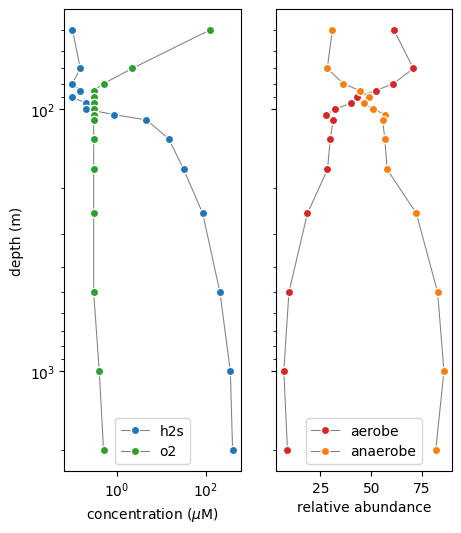

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 6), sharey=True)
ax = ax.ravel() # Flatten the array of axes.

ax[0].invert_yaxis() #, ax[1].invert_yaxis() # Invert the axis, so surface is at the top. 
ax[1].set_yscale('log'), ax[1].set_yscale('log') # Convert depth axis to logscale.
ax[0].set_ylabel('depth (m)')

ax[0].set_xscale('log') # Convert x-axis to logscale.
ax[0].set_xlabel('concentration ($\mu$M)')
ax[0].plot(bs_metadata_df.h2s_uM, bs_metadata_df.depth_m, marker='o', ls='-', lw=0.75, color='grey', markerfacecolor='tab:blue', markeredgecolor='w', label='H$_2$S')
ax[0].plot(bs_metadata_df.o2_uM, bs_metadata_df.depth_m, marker='o', ls='-', lw=0.75, color='grey', markerfacecolor='tab:green', markeredgecolor='w', label='O$_2$')
ax[0].legend(['h2s', 'o2'])

ax[1].set_xlabel('relative abundance')
colors = ['tab:red', 'tab:orange']
ax[1].plot(o2_percents_df['aerobe'], o2_percents_df.depth_m, marker='o', ls='-', lw=0.75, color='grey', markerfacecolor='tab:red', markeredgecolor='w', label='aerobe')
ax[1].plot(o2_percents_df['anaerobe'], o2_percents_df.depth_m, marker='o', ls='-', lw=0.75, color='grey', markerfacecolor='tab:orange', markeredgecolor='w', label='anaerobe')
ax[1].legend(['aerobe', 'anaerobe'])

plt.show()

Linear regression: LinregressResult(slope=3.5168774331407313, intercept=0.2579612836669902, rvalue=0.9066196207355679, pvalue=3.1731511954148023e-06, stderr=0.4539628238653771, intercept_stderr=0.2354988285773936)


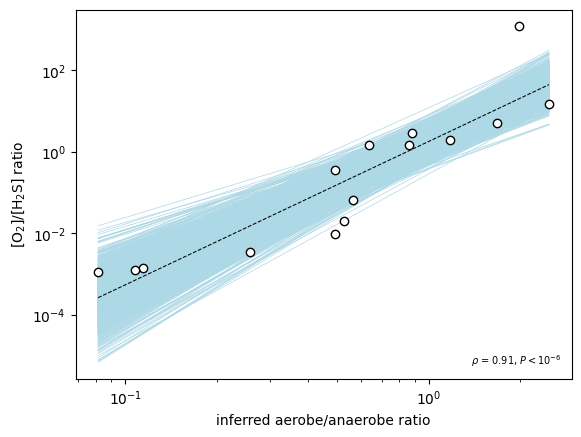

In [21]:
# Do linear regression on the log ratios.
# NOTE: The results of this analysis seem to be a bit different from Josh's, but perhaps not significantly?
reg = linregress(log_aerobe_anaerobe_ratio, log_o2_h2s_ratio)
print('Linear regression:', reg)
x_vals = np.logspace(log_aerobe_anaerobe_ratio.min(), log_aerobe_anaerobe_ratio.max(), 100)
y_vals = reg.intercept + reg.slope * np.log10(x_vals)

fig, ax = plt.subplots()
ax.loglog(aerobe_anaerobe_ratio.values, o2_h2s_ratio.values, marker='o', ls='', color='grey', markerfacecolor='w', markeredgecolor='k')
ax.plot(x_vals, 10**y_vals, color='k', ls='--', lw=0.75, zorder=-1)

# Bootstrap a confidence interval plot manually because seaborns regplot doesn't handle log scale...
for _ in range(1000):
    slope = np.random.normal(reg.slope, reg.stderr)
    intercept = np.random.normal(reg.intercept, reg.intercept_stderr)
    y_vals = intercept + slope * np.log10(x_vals)
    ax.plot(x_vals, 10**y_vals, color='lightblue', ls='-', lw=0.5, zorder=-10)

ax.set_xlabel('inferred aerobe/anaerobe ratio')
ax.set_ylabel('[O$_2$]/[H$_2$S] ratio')
ax.text(0.98, 0.03, '$\\rho$ = {0:.2f}, $P < 10^{{-6}}$'.format(reg.rvalue, reg.pvalue), fontsize=7, transform=ax.transAxes, ha='right', va='bottom')
plt.show()

## Figure 2

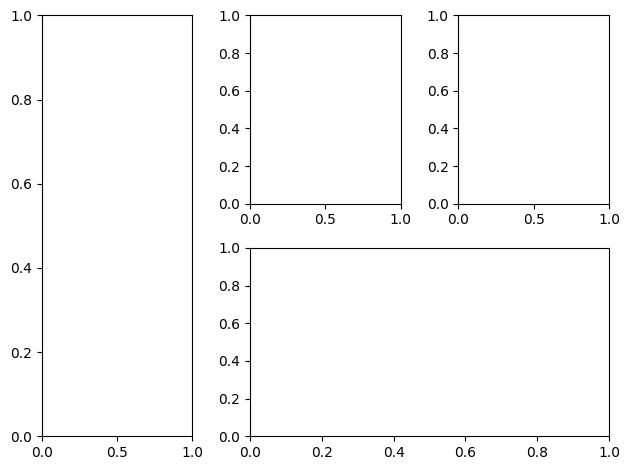

In [31]:
# fig, axes = plt.subplots(nrows=1, ncols=2, width_ratios=[2, 1], figsize=(6.875, 4), constrained_layout=True)
# axes = axes.ravel()
fig = plt.figure(figsize=(7, 4))
grid = fig.add_gridspec()

ax_a = plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=1)
ax_b1 = plt.subplot2grid((2, 3), (0, 1), rowspan=1, colspan=1)
ax_b2 = plt.subplot2grid((2, 3), (0, 2), rowspan=1, colspan=1, sharey=ax_b1)
ax_c = plt.subplot2grid((2, 3), (1, 1), rowspan=1, colspan=2)

plt.tight_layout()
plt.show()
# right_axes = axes[1].subplots(nrows=2, ncols=2, sharey='row', gridspec_kw={'height_ratios': [1.25, 1]})

# plt.sca(leftAx)
# cols = 'habitat,pct_Anaerobe,pct_Aerobe,pct_Facultative'.split(',')
# tmp = mean_EMP_pcts_df.reset_index()
# mask = np.logical_and(tmp.total > 240,
#                       np.logical_not(tmp.habitat.isin(['Host-associated'])))

# sorted = tmp[cols][mask].set_index('habitat').sort_values('pct_Anaerobe', ascending=False)
# sorted.plot(kind='bar', stacked=True, color=default_pal[:3], ax=leftAx, legend=False,
#             edgecolor='k', linewidth=0.5)

# # Printing the total number of MAGs per sample to verify it exceeds 250
# totals = mean_EMP_pcts_df.loc[sorted.index].total
# print(totals)

# plt.legend('Anaerobe,Aerobe,Facultative'.split(','), loc=3)
# plt.ylabel('percent of MAGs in samples')
# plt.xlabel('')
# plt.xticks(rotation=45, ha='right', fontsize=8)
# plt.ylim(0, 100.1)
# leftAx.yaxis.set_major_formatter(mtick.PercentFormatter())

# plt.sca(rightAxs[0, 0])
# # Invert only the first -- also inverts the second since they share a y-axis.
# plt.gca().invert_yaxis()
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(black_sea_metadata.h2s_uM, black_sea_metadata.depth_m, marker='o', ls='-', lw=0.75,
#          color='grey', markerfacecolor=colors['yellow'], markeredgecolor='w', label='H$_2$S')
# plt.plot(black_sea_metadata.o2_uM, black_sea_metadata.depth_m, marker='o', ls='-', lw=0.75,
#          color='grey', markerfacecolor=colors['red'], markeredgecolor='w', label='O$_2$')
# plt.xlabel('concentration ($\mu$M)')
# plt.ylabel('depth (m)')

# plt.sca(rightAxs[0, 1])
# plt.yscale('log')
# for i, col in enumerate('Anaerobe,Aerobe'.split(',')):
#     plt.plot(O2_utilization_pcts[col], O2_utilization_pcts.depth_m, marker='o', ls='-', lw=0.75,
#          color='grey', markerfacecolor=default_pal[i], markeredgecolor='w', label=col)
#plt.ylabel('Depth (m)')
# plt.xlabel('relative abundance')

# # Make a big axis to hold the correlation plot
# gs = rightAxs[1, 0].get_gridspec()
# # remove the underlying axes
# for ax in rightAxs[1, :]:
#     ax.remove()    
# axbig = subfigs[1].add_subplot(gs[1, :])

# plt.sca(axbig)
# plt.loglog(aerobe_anaerobe_ratio, ox_sulfide_ratio, marker='o', ls='', color='grey', markerfacecolor='w', markeredgecolor='k')

# plt.plot(xs, 10**pred_ys, color='k', ls='--', lw=0.75, zorder=-1)
# # bootstrap a confidence interval plot manually because
# # seaborns regplot doesn't handle log scale...
# for _ in range(1000):
#     slope = np.random.normal(reg_res.slope, reg_res.stderr)
#     intercept = np.random.normal(reg_res.intercept, reg_res.intercept_stderr)
#     pred_ys = intercept + slope*np.log10(xs)
#     plt.plot(xs, 10**pred_ys, color=colors['light_blue'], ls='-', lw=0.5, alpha=0.8,
#              zorder=-10)

# plt.xlabel('inferred aerobe/anaerobe ratio')
# plt.ylabel('[O$_2$]/[H$_2$S] ratio')
# plt.text(0.98, 0.03, '$\\rho$ = {0:.2f}, $P < 10^{{-6}}$'.format(reg_res.rvalue, reg_res.pvalue),
#          fontsize=7, transform=plt.gca().transAxes, ha='right', va='bottom')


# plt.savefig('../../results/Fig2.png', dpi=300, facecolor='w')